# Probability parser

`bayesloop` as a probabilistic programming framework is focused on two-level hierarchical models for time series analysis, and is therefore not as flexible as other frameworks. [PyMC3](https://github.com/pymc-devs/pymc3), for example, allows the user to create hierarchical models of any structure and to apply arbitrary arithmetic operations on the random variables contained in the model. While `bayesloop` allows the user to build custom low-level (observation) models and choose from a variety of high-level (transition) models, one has no direct influence on the choice of parameters. In other words, the `Gaussian` observation model includes the parameters *mean* and *standard deviation*, but there is no direct way of evaluating the *variance* or the *ratio of mean and standard deviation* instead. In many applications, however, these combinations or transformed variables are the key to informed desicions! In finance, for example, the performance of a financial asset is often evaluated by its [Sharpe ratio](https://en.wikipedia.org/wiki/Sharpe_ratio) $S$:

$$ S = \frac{\mu - \mu_0}{\sigma} ~,$$

where $\mu$ is the expected return of the financial asset, $\mu_0$ is the risk-free return, and $\sigma$ is the volatility. Assuming Gaussian returns, we can obtain time-varying estimates of $\mu$ and $\sigma$ with a simple `Gaussian` observation model with `bayesloop`, while $\mu_0$ is just a series of given numbers we may obtain from the central bank.

This tutorial shows how to evaluate arithmetic combinations of inferred parameter distributions after the model has been fitted, using the `eval` method of the `Study` class and the `Parser` class. With these tools, we compute the probability that the time-varying Sharpe ratio of a simulated series of returns is greater than one (a common threshold for investing in financial assets).

First, we simulate a fictious series of price fluctuations. Here we assume gradual changes in the expected return, the risk-free return and the volatility. Based on the expected return and the volatility, we sample the observed price fluctuations based on a Gaussian distribution:

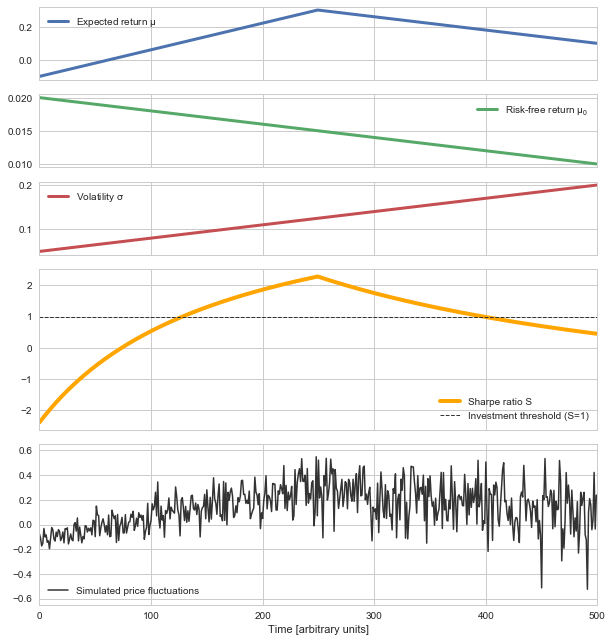

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # plotting
import seaborn as sns           # nicer plots
sns.set_style('whitegrid')      # plot styling
sns.set_color_codes()

import bayesloop as bl
import numpy as np

mu_sim = np.concatenate([np.linspace(-0.1, 0.3, 250), np.linspace(0.3, 0.1, 250)])
sigma_sim = np.linspace(0.05, 0.2, 500)
mu0 = np.linspace(0.02, 0.01, 500)
sharpe_sim = (mu_sim-mu0)/sigma_sim

np.random.seed(123456)
data = mu_sim + sigma_sim*np.random.randn(500)

plt.figure(figsize=(10, 11))
plt.subplot2grid((7, 1), (0, 0))
plt.plot(mu_sim, c='b', lw=3, label='Expected return $\mathregular{\mu}$')
plt.xticks([100, 200, 300, 400], ['', '', '', ''])
plt.xlim([0, 500])
plt.legend(loc='upper left')

plt.subplot2grid((7, 1), (1, 0))
plt.plot(mu0, c='g', lw=3, label='Risk-free return $\mathregular{\mu_0}$')
plt.xticks([100, 200, 300, 400], ['', '', '', ''])
plt.xlim([0, 500])
plt.legend(loc='upper right')

plt.subplot2grid((7, 1), (2, 0))
plt.plot(sigma_sim, c='r', lw=3, label='Volatility $\mathregular{\sigma}$')
plt.xticks([100, 200, 300, 400], ['', '', '', ''])
plt.xlim([0, 500])
plt.legend(loc='upper left')

plt.subplot2grid((7, 1), (3, 0), rowspan=2)
plt.plot(sharpe_sim, lw=4, c='orange', label='Sharpe ratio S')
plt.xticks([100, 200, 300, 400], ['', '', '', ''])
plt.axhline(y=1, c='0.2', ls='dashed', lw=1, label='Investment threshold (S=1)')
plt.xlim([0, 500])
plt.legend(loc='lower right')

plt.subplot2grid((7, 1), (5, 0), rowspan=2)
plt.plot(data, c='0.2', lw=1.5, label='Simulated price fluctuations')
plt.xlim([0, 500])
plt.ylim([-0.65, 0.65])
plt.legend(loc='lower left')
plt.xlabel('Time [arbitrary units]');

To infer the time-varying expected return $\mu$ and volatility $\sigma$ from the simulated price fluctuations, we assume a `Gaussian` observation model. The two parameters of this observation model are themselves subject to a `GaussianRandomWalk`, the transition model of the study. For simplicity, we set fixed magnitudes for the parameter fluctuations (`sigma_mu`, `sigma_stdev`):

In [2]:
S = bl.Study()
S.load(data)

L = bl.om.Gaussian('mu', bl.cint(-0.5, 0.5, 100), 'sigma', bl.oint(0, 0.5, 100))
T = bl.tm.CombinedTransitionModel(
        bl.tm.GaussianRandomWalk('sigma_mu', 0.01, target='mu'),
        bl.tm.GaussianRandomWalk('sigma_stdev', 0.005, target='sigma')
    )

S.set(L, T)
S.fit()

+ Created new study.
+ Successfully imported array.
+ Observation model: Gaussian observations. Parameter(s): ['mu', 'sigma']
+ Transition model: Combined transition model. Hyper-Parameter(s): ['sigma_mu', 'sigma_stdev']
+ Started new fit:
    + Formatted data.
    + Set prior (function): jeffreys. Values have been re-normalized.



    + Finished forward pass.
    + Log10-evidence: 130.79643



    + Finished backward pass.
    + Computed mean parameter values.


Plotting the inferred expected return and volatility against the true underlying values used in the simulation, we find that the time-varying parameter model we defined above nicely captures the variations in the performance of the fictious financial asset:

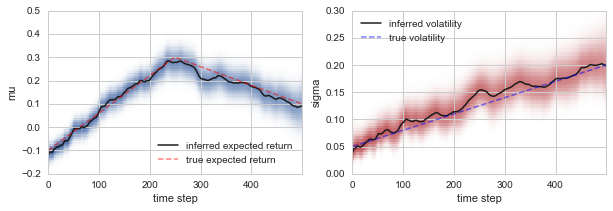

In [3]:
plt.figure(figsize=(10, 3))
plt.subplot2grid((1, 2), (0, 0))
S.plot('mu', color='b', label='inferred expected return')
plt.plot(mu_sim, lw=1.5, c='red', ls='dashed', alpha=0.5, label='true expected return')
plt.ylim([-0.2, 0.5])
plt.legend(loc='lower right')

plt.subplot2grid((1, 2), (0, 1))
S.plot('sigma', color='r', label='inferred volatility')
plt.plot(sigma_sim, lw=1.5, c='blue', ls='dashed', alpha=0.5, label='true volatility')
plt.ylim([0, 0.3])
plt.legend(loc='upper left');

Based on these inferred parameter distributions, we can now evaluate probabilities in the form of inequalities using the `eval` function of the `Study` class. For example, we can evaluate the probability of a positive expected return at time step 50:

In [4]:
S.eval('mu > 0.', t=50);

P(mu > 0.) = 0.2486016146556542


By default, `eval` prints out the resulting probability. This behavior can be controlled with the keyword-argument `silent`. `eval` further returns the value, for further processing:

In [5]:
p = S.eval('mu > 0.', t=50, silent=True)
print(p)

0.248601614656


The keyword-argument `t` is not the only way to define the time step at which to evaluate the probability value. One can also use the `@` operator. In this example, we ask for the probability of a volatility value smaller than 0.2 at `t=400`:

In [6]:
S.eval('sigma@400 < 0.2');

P(sigma@400 < 0.2) = 0.934624296075193


The evaluation of probability values is not restricted to a single time step, one may also be interested whether the expected return at `t=100` is greater than at `t=400`. Note that `bayesloop` does not infer the joint parameter distribution of all time steps, but the conditional joint parameter distributions for each time step iteratively. This means that correlations between the parameter at different time steps are ignored by the `eval` method. Further note that comparing parameters at different time steps may result in a fairly long computation time and a lot of RAM usage, as `bayesloop` has to take into account all possible combinations of parameter values.

In [7]:
S.eval('mu@100 > mu@400');

P(mu@100 > mu@400) = 0.0007986199467668083


The `eval` method further computes arithmetic combinations of different parameters. In our example, `bayesloop` computes the joint parameter distribution of `mu` and `sigma` for each time step. When we ask for the probability that the ratio of `mu` and `sigma` is greater than one, `eval` computes the ratio of the parameters from their joint distribution:

In [8]:
S.eval('mu/sigma > 1', t=100);

P(mu/sigma > 1) = 0.12878704018028345


The parameter ratio above does not yet resemble the Sharpe ratio $S$, as the risk-free return is not inserted yet. The `eval` method does not only support the parsing of parameter names, but also the parsing of plain numbers. Below, we first check the risk-free return at `t=100`, and then insert this number into the query of the `eval` method. We discover that at `t=100`, the probability that the Sharpe ratio $S$ exceeds the value of one is only about 2.3%:

In [9]:
mu0[100]

0.017995991983967938

In [10]:
S.eval('(mu - 0.018)/sigma > 1', t=100);

P((mu - 0.018)/sigma > 1) = 0.023246959985844733


Of course, we can also insert the risk-free return value directly, via string manipulation:

In [11]:
S.eval('(mu - ' + str(mu0[100]) + ')/sigma > 1', t=100);

P((mu - 0.017995991984)/sigma > 1) = 0.023246959985844733


The `eval` method contains a bit of computational overhead, as it has to pre-process all parameter values before every single query. As we want to compute $p(S > 1)$ for *all* 500 time steps, we are better off by using a `Parser` instance. The `Parser` is initialized only once, and then queried repeatedly without computational overhead. Below we show one example with a single query to the `Parser` instance, and subsequently repeat the query for all time steps:

In [12]:
P = bl.Parser(S)
P('(mu - ' + str(mu0[100]) + ')/sigma > 1', t=100);

P((mu - 0.017995991984)/sigma > 1) = 0.023246959985844733


In [13]:
p_invest = []

for t in range(500):
    p_invest.append(P('(mu - ' + str(mu0[t]) + ')/sigma > 1', t=t, silent=True))

Finally, we may plot the probability that our probabilistic, time-varying Sharpe ratio $S$ is greater than one for each time step, together with the underlying true values of $S$ in the simulation. We find that $p(S > 1)$ attains a value of $\approx 0.5$ at the times when $S=1$ in the simulation, and increases further as $S > 1$. Consequently, we find that  $p(S > 1) < 0.5$ for $S < 1$ in the simulation. This example thereby illustrates how the combination of inferred time-varying parameters can help to create robust indicators for desicion making in the presence of uncertainty.

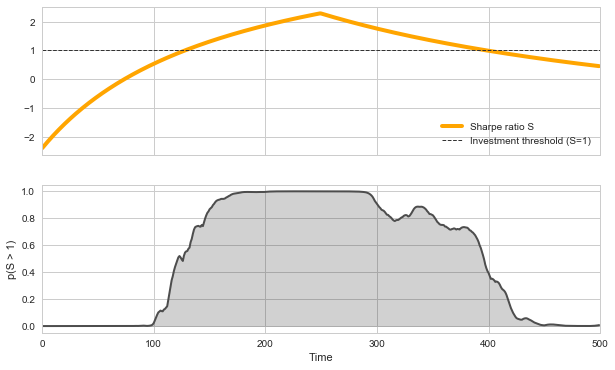

In [14]:
plt.figure(figsize=(10, 6))

plt.subplot2grid((2, 1), (0, 0))
plt.plot(sharpe_sim, lw=4, c='orange', label='Sharpe ratio S')
plt.xticks([100, 200, 300, 400], ['', '', '', ''])
plt.axhline(y=1, c='0.2', ls='dashed', lw=1, label='Investment threshold (S=1)')
plt.xlim([0, 500])
plt.legend(loc='lower right')

plt.subplot2grid((2, 1), (1, 0))
plt.plot(p_invest, c='0.3', lw=2)
plt.fill_between(range(500), p_invest, 0, color='k', alpha=0.2)
plt.xlim([0, 500])
plt.ylim([-0.05, 1.05])
plt.xlabel('Time')
plt.ylabel('p(S > 1)');

So far, we have parsed either parameter names or plain numbers in the queries to the `eval` method or the `Parser` instance. In many applications, however, one also needs to compute the `sqrt`, or the `cos` of a parameter. `bayesloop`'s probability parser therefore allows to parse any function contained in the `numpy` module. Note, however, that only functions which preserve the shape of an input array will return valid results (e.g. using `sum` will not work).

In [15]:
P('sin(mu) + cos(sigma) > 1', t=50);

P(sin(mu) + cos(sigma) > 1) = 0.2479001934193268


On a final note, the `Parser` class also handles (hyper-)parameters of different study instances. For example, one could imagine to run one study `S1` (which may be a `Study`, `HyperStudy`, `ChangepointStudy` or an `OnlineStudy`) to analyze price fluctuations of a financial asset, and another study `S2` to analyze the frequency of market-related Twitter messages. After fitting data points, one can initialize a `Parser` instance that takes into account both studies:
```
P = bl.Parser(S1, S2)
```
Note that the two studies `S1` and `S2` must not contain duplicate (hyper-)parameter names! This allows to create performance indicators that take into account different kinds of information (e.g. pricing data and social media activity).